In [2]:
import os, warnings
from pathlib import Path

import numpy as np
import dynamo as dyn
import spateo as st
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

2023-10-03 00:38:04.225279: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-03 00:38:04.247345: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-03 00:38:04.612984: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from typing import Optional, Tuple, Union

import matplotlib as mpl
import numpy as np
from pyvista import PolyData, UniformGrid, UnstructuredGrid

try:
    from typing import Literal
except ImportError:
    from typing_extensions import Literal


def add_model_labels(
        model: Union[PolyData, UnstructuredGrid, UniformGrid],
        labels: np.ndarray,
        key_added: str = "groups",
        where: Literal["point_data", "cell_data"] = "cell_data",
        colormap: Union[str, list, dict, np.ndarray] = "rainbow",
        alphamap: Union[float, list, dict, np.ndarray] = 1.0,
        mask_color: Optional[str] = "gainsboro",
        mask_alpha: Optional[float] = 0.0,
        inplace: bool = False,
) -> Tuple[Optional[PolyData or UnstructuredGrid], Optional[Union[str]]]:
    model = model.copy() if not inplace else model
    labels = np.asarray(labels).flatten()

    cu_arr = np.sort(np.unique(labels), axis=0).astype(object)
    raw_labels_hex = labels.copy().astype(object)
    raw_labels_alpha = labels.copy().astype(object)
    raw_labels_hex[raw_labels_hex == "mask"] = mpl.colors.to_hex(mask_color)
    raw_labels_alpha[raw_labels_alpha == "mask"] = mask_alpha

    # Set raw hex.
    if isinstance(colormap, str):
        if colormap in list(mpl.colormaps()):
            lscmap = mpl.cm.get_cmap(colormap)
            raw_hex_list = [mpl.colors.to_hex(lscmap(i)) for i in np.linspace(0, 1, len(cu_arr))]
            for label, color in zip(cu_arr, raw_hex_list):
                raw_labels_hex[raw_labels_hex == label] = color
        else:
            raw_labels_hex[raw_labels_hex != "mask"] = mpl.colors.to_hex(colormap)
    elif isinstance(colormap, dict):
        for label, color in colormap.items():
            raw_labels_hex[raw_labels_hex == label] = mpl.colors.to_hex(color)
    elif isinstance(colormap, list) or isinstance(colormap, np.ndarray):
        raw_hex_list = np.array([mpl.colors.to_hex(color) for color in colormap]).astype(object)
        for label, color in zip(cu_arr, raw_hex_list):
            raw_labels_hex[raw_labels_hex == label] = color
    else:
        raise ValueError("`colormap` value is wrong." "\nAvailable `colormap` types are: `str`, `list` and `dict`.")

    # Set raw alpha.
    if isinstance(alphamap, float) or isinstance(alphamap, int):
        raw_labels_alpha[raw_labels_alpha != "mask"] = alphamap
    elif isinstance(alphamap, dict):
        for label, alpha in alphamap.items():
            raw_labels_alpha[raw_labels_alpha == label] = alpha
    elif isinstance(alphamap, list) or isinstance(alphamap, np.ndarray):
        raw_labels_alpha = np.asarray(alphamap).astype(object)
    else:
        raise ValueError(
            "`alphamap` value is wrong." "\nAvailable `alphamap` types are: `float`, `list` and `dict`."
        )

    # Set rgba.
    labels_rgba = [mpl.colors.to_rgba(c, alpha=a) for c, a in zip(raw_labels_hex, raw_labels_alpha)]
    labels_rgba = np.array(labels_rgba).astype(np.float32)

    # Added rgba of the labels.
    if where == "point_data":
        model.point_data[f"{key_added}_rgba"] = labels_rgba
    else:
        model.cell_data[f"{key_added}_rgba"] = labels_rgba

    plot_cmap = None

    # Added labels.
    if where == "point_data":
        model.point_data[key_added] = labels
    else:
        model.cell_data[key_added] = labels

    return model if not inplace else None, plot_cmap

## Load the data

In [4]:
sample_id = "E7_8h"
os.chdir(f"/media/pc001/Yao/Projects/Project_drosophila/Data_v4/migration-hotspot/drosophila_{sample_id}_germ_layer_new")
cpo = [(41, 1209, 57), (13, 8, -3), (0, 0, 1)]
out_image_path = f"image/CNS_morphofield/morpho_curvature"
Path(out_image_path).mkdir(parents=True, exist_ok=True)

In [5]:
cns_adata = st.read_h5ad(f"h5ad/{sample_id}_CNS_v4.h5ad")

cns_pc = st.tdr.read_model(f"morpho_models/CNS_morphometrics_pc_model.vtk")
cns_mesh = st.tdr.read_model(f"morpho_models/CNS_morphometrics_mesh_model.vtk")
trajectory_model = st.tdr.read_model(f"morpho_models/CNS_morphofield_trajectory_model.vtk")
cns_adata

AnnData object with n_obs × n_vars = 4656 × 7923
    obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'scc', 'anno_tissue_new', 'V_z', 'anno_germ_layer_new', 'backbone_nodes', 'backbone_scc', 'segments', 'V_x', 'morpho_acceleration', 'morpho_curvature', 'morpho_curl', 'morpho_torsion'
    uns: 'VecFld_morpho', 'glm_degs', 'log1p', 'pp'
    obsm: '2d_realign_spatial', '3d_align_spatial', 'V_cells_mapping', 'X_cells_mapping', 'X_pca', 'X_umap', 'morpho_acceleration', 'morpho_curl', 'morpho_curvature', 'morpho_velocity', 'raw_spatial', 'tdr_spatial'
    layers: 'X_counts', 'spliced', 'unspliced'

In [8]:
cns_pc = st.tdr.interactive_rectangle_clip(model=cns_pc, key="tissue", invert=True)[0]
cns_adata = cns_adata[np.asarray(cns_pc.point_data["obs_index"]), :].copy()
cns_adata = cns_adata[cns_adata.layers["X_counts"].sum(axis=1)!=0, cns_adata.layers["X_counts"].sum(axis=0)!=0]
cns_adata

View of AnnData object with n_obs × n_vars = 2338 × 7621
    obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'scc', 'anno_tissue_new', 'V_z', 'anno_germ_layer_new', 'backbone_nodes', 'backbone_scc', 'segments', 'V_x', 'morpho_acceleration', 'morpho_curvature', 'morpho_curl', 'morpho_torsion'
    uns: 'VecFld_morpho', 'glm_degs', 'log1p', 'pp'
    obsm: '2d_realign_spatial', '3d_align_spatial', 'V_cells_mapping', 'X_cells_mapping', 'X_pca', 'X_umap', 'morpho_acceleration', 'morpho_curl', 'morpho_curvature', 'morpho_velocity', 'raw_spatial', 'tdr_spatial'
    layers: 'X_counts', 'spliced', 'unspliced'

In [9]:
morphometrics_keys = ["morpho_acceleration", "morpho_curvature", "morpho_curl", "morpho_torsion"]
for mk in morphometrics_keys:
    pc_index=cns_pc.point_data["obs_index"].tolist()
    mmvalue = cns_adata[pc_index, :].obs[mk].values
    st.tdr.add_model_labels(model=cns_pc, labels=mmvalue, key_added=mk, where="point_data",inplace=True, colormap="afmhot_r")
    
    st.pl.three_d_plot(
        model=cns_pc,
        key=mk,
        model_style="points",
        model_size=10,
        opacity=1,
        colormap="afmhot_r", # Spectral_r
        show_legend=True,
        jupyter=False,
        background="white",
        cpo=cpo,
        window_size=(2560, 2048),
        text=mk,
        # filename=os.path.join(out_image_path, f"CNS_morphometrics_{mk}.pdf")
    )

## GLM DEGs

In [9]:
cns_adata.X= cns_adata.layers["X_counts"].copy()
#sc.pp.normalize_total(cns_adata)
#sc.pp.log1p(cns_adata)

In [21]:
st.tl.glm_degs(
    adata=cns_adata,
    fullModelFormulaStr=f'~cr(morpho_curvature, df=3)',
    key_added="glm_degs",
    qval_threshold=0.05,
    llf_threshold=-100,
)
print(cns_adata.uns["glm_degs"]["glm_result"])

|-----? Gene expression matrix must be normalized by the size factor, please check if the input gene expression matrix is correct.If you don't have the size factor normalized gene expression matrix, please run `dynamo.pp.normalize_cell_expr_by_size_factors(skip_log = True)`.
|-----> [Detecting genes via Generalized Additive Models (GAMs)] in progress: 100.0000%
|-----> [Detecting genes via Generalized Additive Models (GAMs)] finished [128.8759s]
                 status family  log-likelihood          pval          qval
Abd-B                ok    NB2     -355.493744  6.304641e-22  4.781439e-18
mt:lrRNA             ok    NB2    -5745.250977  3.094979e-20  1.173616e-16
bnb                  ok    NB2     -605.630981  3.263692e-15  8.250612e-12
mt:CoIII             ok    NB2    -3980.828857  1.960803e-12  3.717683e-09
Srlp                 ok    NB2     -121.333206  2.446493e-11  3.710840e-08
...                 ...    ...             ...           ...           ...
Arl5                 ok  

In [53]:
cns_adata.uns["glm_degs"]["glm_result"].loc[["spz3"], :]
# ["sna", "esg", "wor", "ftz", "pdm2", "eve"]

KeyError: "None of [Index(['spz3'], dtype='object')] are in the [index]"

In [56]:
cns_adata.uns["glm_degs"]["glm_result"]

status family  log-likelihood          pval          qval
Abd-B                ok    NB2     -355.493744  6.304641e-22  4.781439e-18
mt:lrRNA             ok    NB2    -5745.250977  3.094979e-20  1.173616e-16
bnb                  ok    NB2     -605.630981  3.263692e-15  8.250612e-12
mt:CoIII             ok    NB2    -3980.828857  1.960803e-12  3.717683e-09
Srlp                 ok    NB2     -121.333206  2.446493e-11  3.710840e-08
...                 ...    ...             ...           ...           ...
Arl5                 ok    NB2     -140.600677  5.705607e-03  4.856490e-02
CG11122              ok    NB2     -157.997055  6.032839e-03  4.914398e-02
trio                 ok    NB2     -324.002533  6.134229e-03  4.938640e-02
E(spl)malpha-BFM     ok    NB2     -460.335999  6.132294e-03  4.984707e-02
DUBAI                ok    NB2     -170.683212  6.149305e-03  4.993183e-02

[569 rows x 5 columns]

In [42]:
glm_data = cns_adata.uns["glm_degs"]["glm_result"]
glm_data= glm_data.loc[glm_data["log-likelihood"] >= -1000, :]
# glm_data= glm_data.loc[glm_data["log-likelihood"] <= -500, :]
# glm_data= glm_data.loc[glm_data["pval"] >= 1e-10, :]
glm_data= glm_data.loc[glm_data["pval"] <= 1e-5, :]
print(glm_data)

                    status family  log-likelihood          pval          qval
Abd-B                   ok    NB2     -355.493744  6.304641e-22  4.781439e-18
bnb                     ok    NB2     -605.630981  3.263692e-15  8.250612e-12
Srlp                    ok    NB2     -121.333206  2.446493e-11  3.710840e-08
UQCR-C1                 ok    NB2     -302.655914  9.965789e-11  1.259676e-07
gcl                     ok    NB2     -247.633240  4.351864e-10  4.125567e-07
CG5708                  ok    NB2     -238.800964  3.956680e-09  2.884689e-06
sti                     ok    NB2     -835.472229  4.184016e-09  2.884689e-06
Orc5                    ok    NB2     -145.407150  2.054944e-08  1.038980e-05
IntS6                   ok    NB2     -146.021973  3.800258e-08  1.695362e-05
rpr                     ok    NB2     -397.559387  9.699003e-08  3.677862e-05
hb                      ok    NB2     -306.619629  1.610951e-07  5.638825e-05
lost                    ok    NB2     -785.362549  1.635735e-07 

In [44]:
st.pl.glm_fit(
    adata=cns_adata,
    genes=list(glm_data.index),
    ncols=5,
    feature_x="morpho_curvature",
    feature_y="expression",
    glm_key="glm_degs",
    save_show_or_return="all",
    color_key="morpho_curvature",
    color_key_cmap="vlag",
    show_legend=False,
    save_kwargs=dict(path=os.path.join(out_image_path, f"{sample_id}_CNS_morpho_curvature_glm_degs_fit"), prefix=None, ext="pdf", dpi=300)
)

Saving figure to image/CNS_morphofield/morpho_curvature/E7_8h_CNS_morpho_curvature_glm_degs_fit.pdf...
Done


(<Figure size 3000x4800 with 112 Axes>,
 [<AxesSubplot:xlabel='morpho_curvature', ylabel='mu'>,
  <AxesSubplot:xlabel='morpho_curvature', ylabel='mu'>,
  <AxesSubplot:xlabel='morpho_curvature', ylabel='mu'>,
  <AxesSubplot:xlabel='morpho_curvature', ylabel='mu'>,
  <AxesSubplot:xlabel='morpho_curvature', ylabel='mu'>,
  <AxesSubplot:xlabel='morpho_curvature', ylabel='mu'>,
  <AxesSubplot:xlabel='morpho_curvature', ylabel='mu'>,
  <AxesSubplot:xlabel='morpho_curvature', ylabel='mu'>,
  <AxesSubplot:xlabel='morpho_curvature', ylabel='mu'>,
  <AxesSubplot:xlabel='morpho_curvature', ylabel='mu'>,
  <AxesSubplot:xlabel='morpho_curvature', ylabel='mu'>,
  <AxesSubplot:xlabel='morpho_curvature', ylabel='mu'>,
  <AxesSubplot:xlabel='morpho_curvature', ylabel='mu'>,
  <AxesSubplot:xlabel='morpho_curvature', ylabel='mu'>,
  <AxesSubplot:xlabel='morpho_curvature', ylabel='mu'>,
  <AxesSubplot:xlabel='morpho_curvature', ylabel='mu'>,
  <AxesSubplot:xlabel='morpho_curvature', ylabel='mu'>,
  <AxesS

In [45]:
cns_adata.X= cns_adata.layers["X_counts"].copy()
sc.pp.normalize_total(cns_adata)
sc.pp.log1p(cns_adata)
for gn in list(glm_data.index):
    _gn = str(gn).replace(":", "_") if ":" in gn else gn
    
    out_image_genes = os.path.join(out_image_path, "curvature_genes")
    Path(out_image_genes).mkdir(parents=True, exist_ok=True)
    
    pc_index=cns_pc.point_data["obs_index"].tolist()
    exp = cns_adata[pc_index, gn].X.A.flatten()
    exp[exp <= 0] = 0
    
    amap = exp.copy()
    amap = amap / np.max(amap)
    amap[amap <= 0.2] = 0.2
    add_model_labels(model=cns_pc, labels=exp, key_added=gn, alphamap=amap, where="point_data",inplace=True, colormap="afmhot_r")
    
    st.pl.three_d_plot(
        model=cns_pc,
        key=gn,
        model_style="points",
        model_size=14,
        opacity=1,
        colormap=None,
        show_legend=True,
        jupyter=False,
        off_screen=True,
        cpo=cpo,
        window_size=(2560, 2048),
        text=gn,
        filename=os.path.join(out_image_genes, f"{sample_id}_CNS_morpho_curvature_model_{_gn}.pdf")
    )

## GO term

In [46]:
import gseapy as gp
gp.get_library_name(organism="fly")

['Allele_LoF_Phenotypes_from_FlyBase_2017',
 'Allele_Phenotypes_from_FlyBase_2017',
 'Anatomy_AutoRIF',
 'Anatomy_AutoRIF_Predicted_zscore',
 'Anatomy_GeneRIF',
 'Anatomy_GeneRIF_Predicted_zscore',
 'Coexpression_Predicted_GO_Biological_Process_2018',
 'Coexpression_Predicted_GO_Cellular_Component_2018',
 'Coexpression_Predicted_GO_Molecular_Function_2018',
 'GO_Biological_Process_2018',
 'GO_Biological_Process_AutoRIF',
 'GO_Biological_Process_AutoRIF_Predicted_zscore',
 'GO_Biological_Process_GeneRIF',
 'GO_Biological_Process_GeneRIF_Predicted_zscore',
 'GO_Cellular_Component_2018',
 'GO_Cellular_Component_AutoRIF',
 'GO_Cellular_Component_AutoRIF_Predicted_zscore',
 'GO_Cellular_Component_GeneRIF',
 'GO_Cellular_Component_GeneRIF_Predicted_zscore',
 'GO_Molecular_Function_2018',
 'GO_Molecular_Function_AutoRIF',
 'GO_Molecular_Function_AutoRIF_Predicted_zscore',
 'GO_Molecular_Function_GeneRIF',
 'GO_Molecular_Function_GeneRIF_Predicted_zscore',
 'Human_Disease_from_FlyBase_2017',
 

In [49]:
 # GO-biologial process
go_folder = os.path.join(out_image_path, f"{sample_id}_morpho_curvature_GO_all")
Path(go_folder).mkdir(parents=True, exist_ok=True)

selected_genes =list (glm_data.index)
go_bp = gp.enrichr(
        gene_list=selected_genes,
        gene_sets="GO_Biological_Process_2018",
        organism="fly",
        outdir=go_folder,
        no_plot=True,
        verbose=True
)

2023-10-03 00:05:56,873 [INFO] Run: GO_Biological_Process_2018 
2023-10-03 00:06:06,296 [INFO] Save enrichment results for GO_Biological_Process_2018 
2023-10-03 00:06:06,298 [INFO] Done.


In [50]:
go_bp_results = pd.read_csv(os.path.join(go_folder, f"GO_Biological_Process_2018.fly.enrichr.reports.txt"), sep="\t")
gp.barplot(go_bp_results, column='Combined Score', title='GO_Biological_Process_2018', cutoff=0.05, top_term=50, figsize=(5, 20),
            ofname=os.path.join(go_folder, f"{sample_id}_morpho_curvature_go_bp_selected_barplot.pdf"))
gp.dotplot(go_bp_results, column='Combined Score', title='GO_Biological_Process_2023', cmap='viridis_r', cutoff=0.05, top_term=50, figsize=(5, 20),
            ofname=os.path.join(go_folder, f"{sample_id}_morpho_curvature_go_bp_selected_dotplot.pdf"))

## Checking genes

In [20]:
completed_data = []
for gn in selected_genes:
    data = germ_adata.uns["glm_degs"]["correlation"][gn]
    data = data[["morpho_acceleration", "expression"]]
    data = data[data["expression"] != 0]
    data["backbone_nodes"] = germ_adata.obs.loc[data.index, "backbone_nodes"]
    data["GNs"] = gn
    
    # data.sort_values(by="morpho_acceleration", ascending=True, axis=0, inplace=True)
    completed_data.append(data)

completed_data = pd.concat(completed_data, axis=0)
completed_data

morpho_acceleration  \
338-E8-10_b_S06-E8-10_b_S06-E8-10_b_S06-E8-10_b...         1.190877e-06   
779-E8-10_b_S07-E8-10_b_S07-E8-10_b_S07-E8-10_b...         2.762144e-06   
197-E8-10_b_S08-E8-10_b_S08-E8-10_b_S08-E8-10_b...         9.601979e-07   
714-E8-10_b_S10-E8-10_b_S10-E8-10_b_S10-E8-10_b...         1.234863e-06   
1197-E8-10_b_S11-E8-10_b_S11-E8-10_b_S11-E8-10_...         5.297966e-07   
...                                                                 ...   
1038-E8-10_b_S25-E8-10_b_S25-E8-10_b_S25-E8-10_...         3.591070e-07   
713-E8-10_b_S17-E8-10_b_S17-E8-10_b_S17-E8-10_b...         3.028146e-07   
921-E8-10_b_S20-E8-10_b_S20-E8-10_b_S20-E8-10_b...         7.150141e-08   
673-E8-10_b_S21-E8-10_b_S21-E8-10_b_S21-E8-10_b...         1.369025e-07   
893-E8-10_b_S22-E8-10_b_S22-E8-10_b_S22-E8-10_b...         1.776077e-07   

                                                    expression  \
338-E8-10_b_S06-E8-10_b_S06-E8-10_b_S06-E8-10_b...    0.507023   
779-E8-10_b_S07-E8-10_b_S07-E8-10_b_S07-E8-10_b...    0.333866   
197-E8-10_b_S08-E8-10_b_S08-E8-10_b_S08-E8-10_b...    0.533244   
714-E8-10_b_S10-E8-10_b_S10-E8-10_b_S10-E8-10_b...    0.493087   
1197-E8-10_b_S11-E8-10_b_S11-E8-10_b_S11-E8-10_...    0.530747   
...                                                        ...   
1038-E8-10_b_S25-E8-10_b_S25-E8-10_b_S25-E8-10_...    1.333732   
713-E8-10_b_S17-E8-10_b_S17-E8-10_b_S17-E8-10_b...    0.547867   
921-E8-10_b_S20-E8-10_b_S20-E8-10_b_S20-E8-10_b...    0.530747   
673-E8-10_b_S21-E8-10_b_S21-E8-10_b_S21-E8-10_b...    0.752633   
893-E8-10_b_S22-E8-10_b_S22-E8-10_b_S22-E8-10_b...    0.897323   

                                                    backbone_nodes   GNs  
338-E8-10_b_S06-E8-10_b_S06-E8-10_b_S06-E8-10_b...              44  Gmap  
779-E8-10_b_S07-E8-10_b_S07-E8-10_b_S07-E8-10_b...              47  Gmap  
197-E8-10_b_S08-E8-10_b_S08-E8-10_b_S08-E8-10_b...              34  Gmap  
714-E8-10_b_S10-E8-10_b_S10-E8-10_b_S10-E8-10_b...              44  Gmap  
1197-E8-10_b_S11-E8-10_b_S11-E8-10_b_S11-E8-10_...              32  Gmap  
...                                                            ...   ...  
1038-E8-10_b_S25-E8-10_b_S25-E8-10_b_S25-E8-10_...               4   clu  
713-E8-10_b_S17-E8-10_b_S17-E8-10_b_S17-E8-10_b...               8   clu  
921-E8-10_b_S20-E8-10_b_S20-E8-10_b_S20-E8-10_b...               6   clu  
673-E8-10_b_S21-E8-10_b_S21-E8-10_b_S21-E8-10_b...               7   clu  
893-E8-10_b_S22-E8-10_b_S22-E8-10_b_S22-E8-10_b...               6   clu  

[4826 rows x 4 columns]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


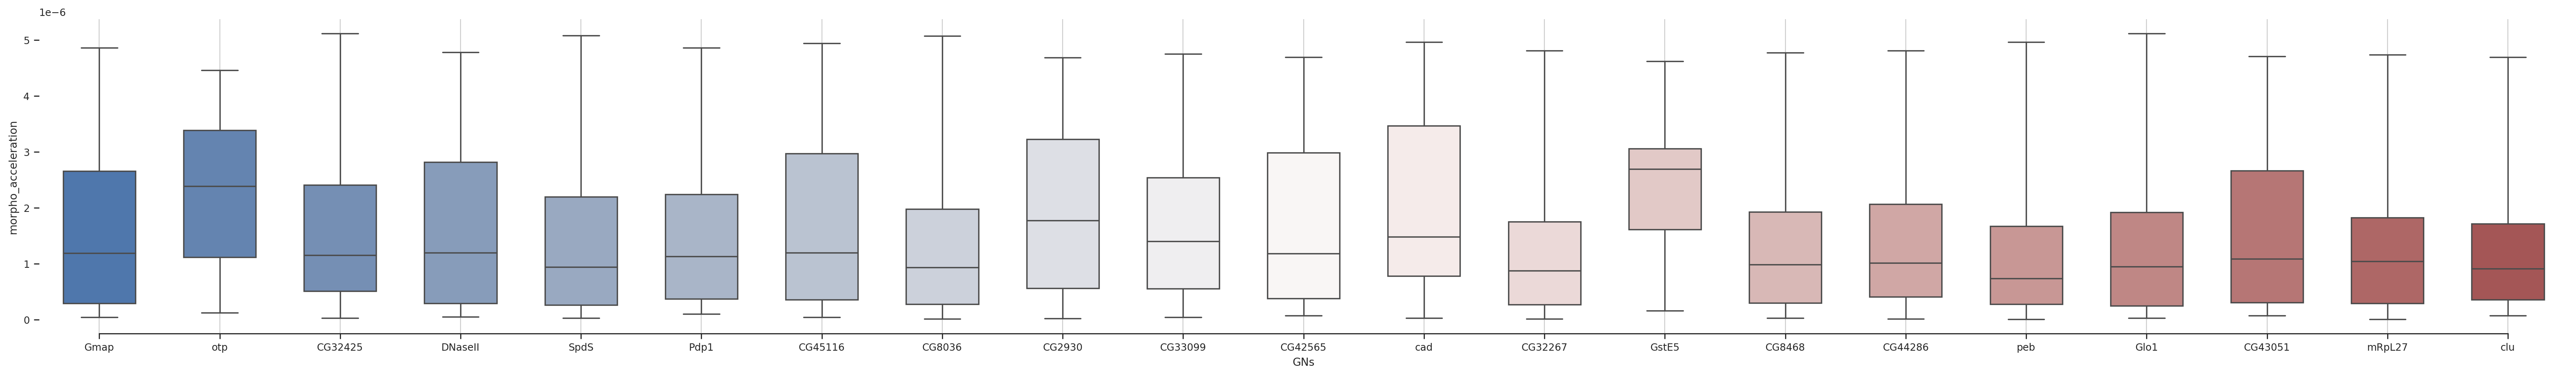

In [21]:
sns.set_theme(context="paper", style="ticks", font="Arial")
f, ax = plt.subplots(figsize=(40, 5))

# Plot the orbital period with horizontal boxes
sns.boxplot(x="GNs", y="morpho_acceleration", data=completed_data, whis=[0, 100], width=.6, palette="vlag")

# Tweak the visual presentation
ax.xaxis.grid(True)
sns.despine(trim=True, left=True)
plt.savefig(os.path.join(out_image_path, f"{sample_id}_germband_morpho_acceleration_glm_degs_boxplot.pdf"), dpi=300, format="pdf", bbox_inches="tight")
plt.show()

In [24]:
completed_mean_data = []
for gn in glm_data.index:
    data = germ_adata.uns["glm_degs"]["correlation"][gn]
    data = data[["morpho_acceleration", "expression"]]
    data = data[data["expression"] != 0]
    data["backbone_nodes"] = germ_adata.obs.loc[data.index, "backbone_nodes"]
    mean_data = data.mean(axis = 0)
    mean_data["GNs"] = gn
    completed_mean_data.append(mean_data)

completed_mean_data = pd.concat(completed_mean_data, axis=1).T
completed_mean_data.sort_values(by="backbone_nodes", ascending=False, axis=0, inplace=True)
completed_mean_data.index = range(len(completed_mean_data.index))
print(completed_mean_data)

   morpho_acceleration expression backbone_nodes          GNs
0             0.000002   1.081442      42.857143        GstE5
1             0.000002    0.86391      42.252747        Abd-B
2             0.000002   1.008506       41.62963  lncRNA:iab8
3             0.000002   0.952262      40.544118          otp
4             0.000002   0.930798      38.927835        Acbp5
..                 ...        ...            ...          ...
81                 0.0   0.872667            8.8  PH4alphaSG1
82                 0.0     0.7436       8.076923        Optix
83                 0.0   0.802905       7.545455          toy
84                 0.0   0.826731       6.047619       TfAP-2
85                 0.0   0.900289       4.761905           gt

[86 rows x 4 columns]


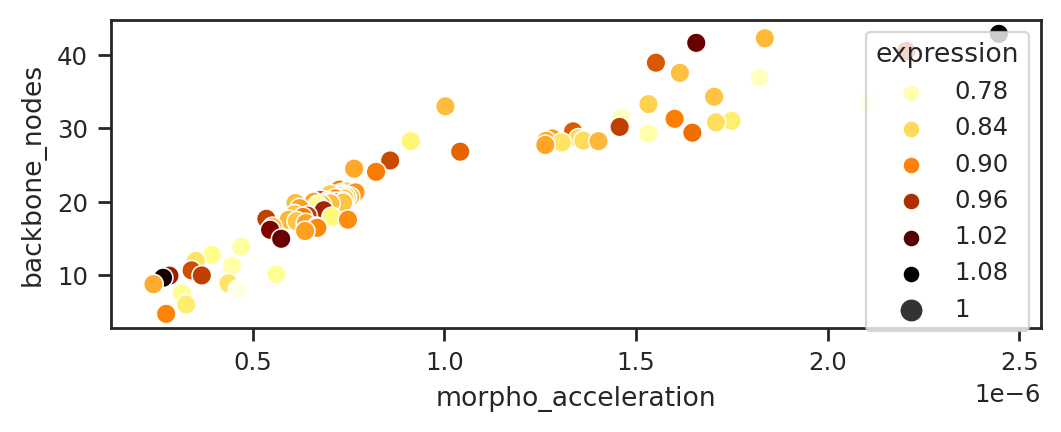

In [25]:
sns.set_theme(context="paper", style="ticks", font="Arial")
f, ax = plt.subplots(figsize=(6, 2))
sns.scatterplot(x="morpho_acceleration", y="backbone_nodes", data=completed_mean_data, hue="expression", palette="afmhot_r", size=1, sizes=(50, 100), ax=ax)
#scatter = ax.scatter(x=completed_mean_data["morpho_acceleration"], y=completed_mean_data["backbone_nodes"], c=completed_mean_data["expression"], vmin=0.6, vmax=1.1, cmap="afmhot_r")
#legend1 = ax.legend(*scatter.legend_elements(num=5), loc="upper left", title="Ranking")
plt.savefig(os.path.join(out_image_path, f"{sample_id}_germband_morpho_acceleration_glm_degs_mean_points.pdf"), dpi=300, format="pdf", bbox_inches="tight")
plt.show()

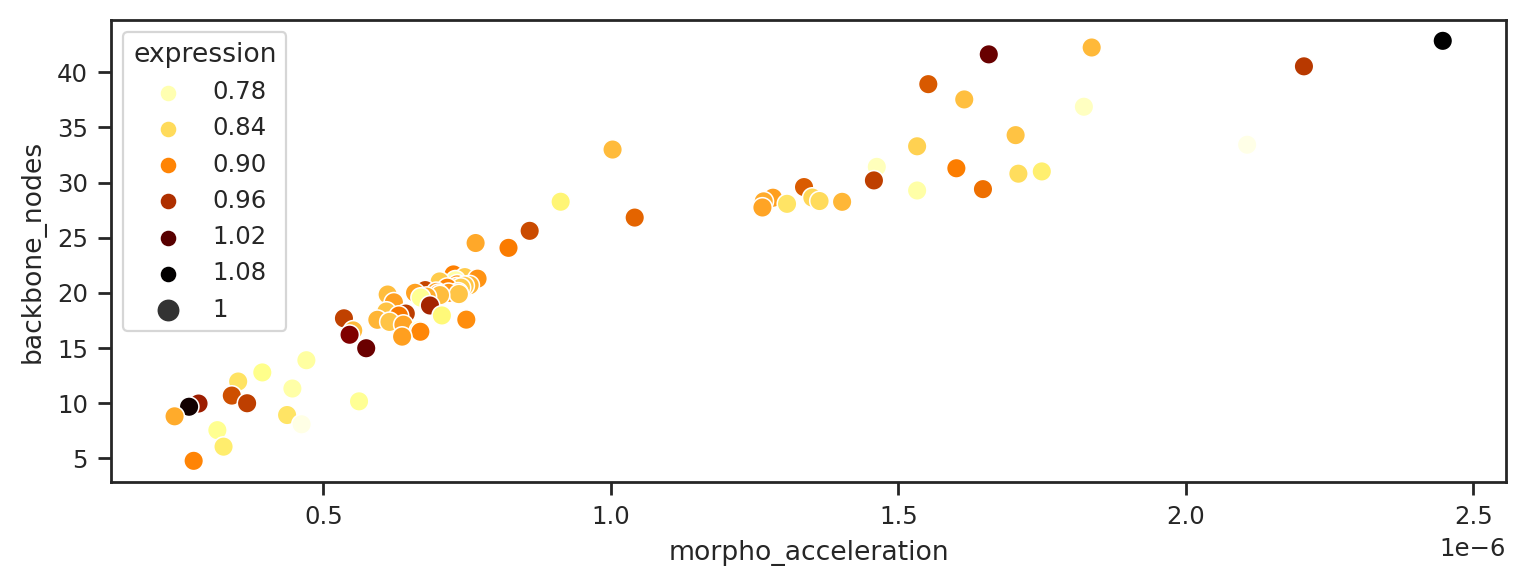

In [26]:
sns.set_theme(context="paper", style="ticks", font="Arial")
f, ax = plt.subplots(figsize=(9, 3))
sns.scatterplot(x="morpho_acceleration", y="backbone_nodes", data=completed_mean_data, hue="expression", palette="afmhot_r", size=1, sizes=(50, 100), ax=ax)
#scatter = ax.scatter(x=completed_mean_data["morpho_acceleration"], y=completed_mean_data["backbone_nodes"], c=completed_mean_data["expression"], vmin=0.6, vmax=1.1, cmap="afmhot_r")
#legend1 = ax.legend(*scatter.legend_elements(num=5), loc="upper left", title="Ranking")
plt.savefig(os.path.join(out_image_path, f"{sample_id}_germband_morpho_acceleration_glm_degs_mean_points_2.pdf"), dpi=300, format="pdf", bbox_inches="tight")
plt.show()

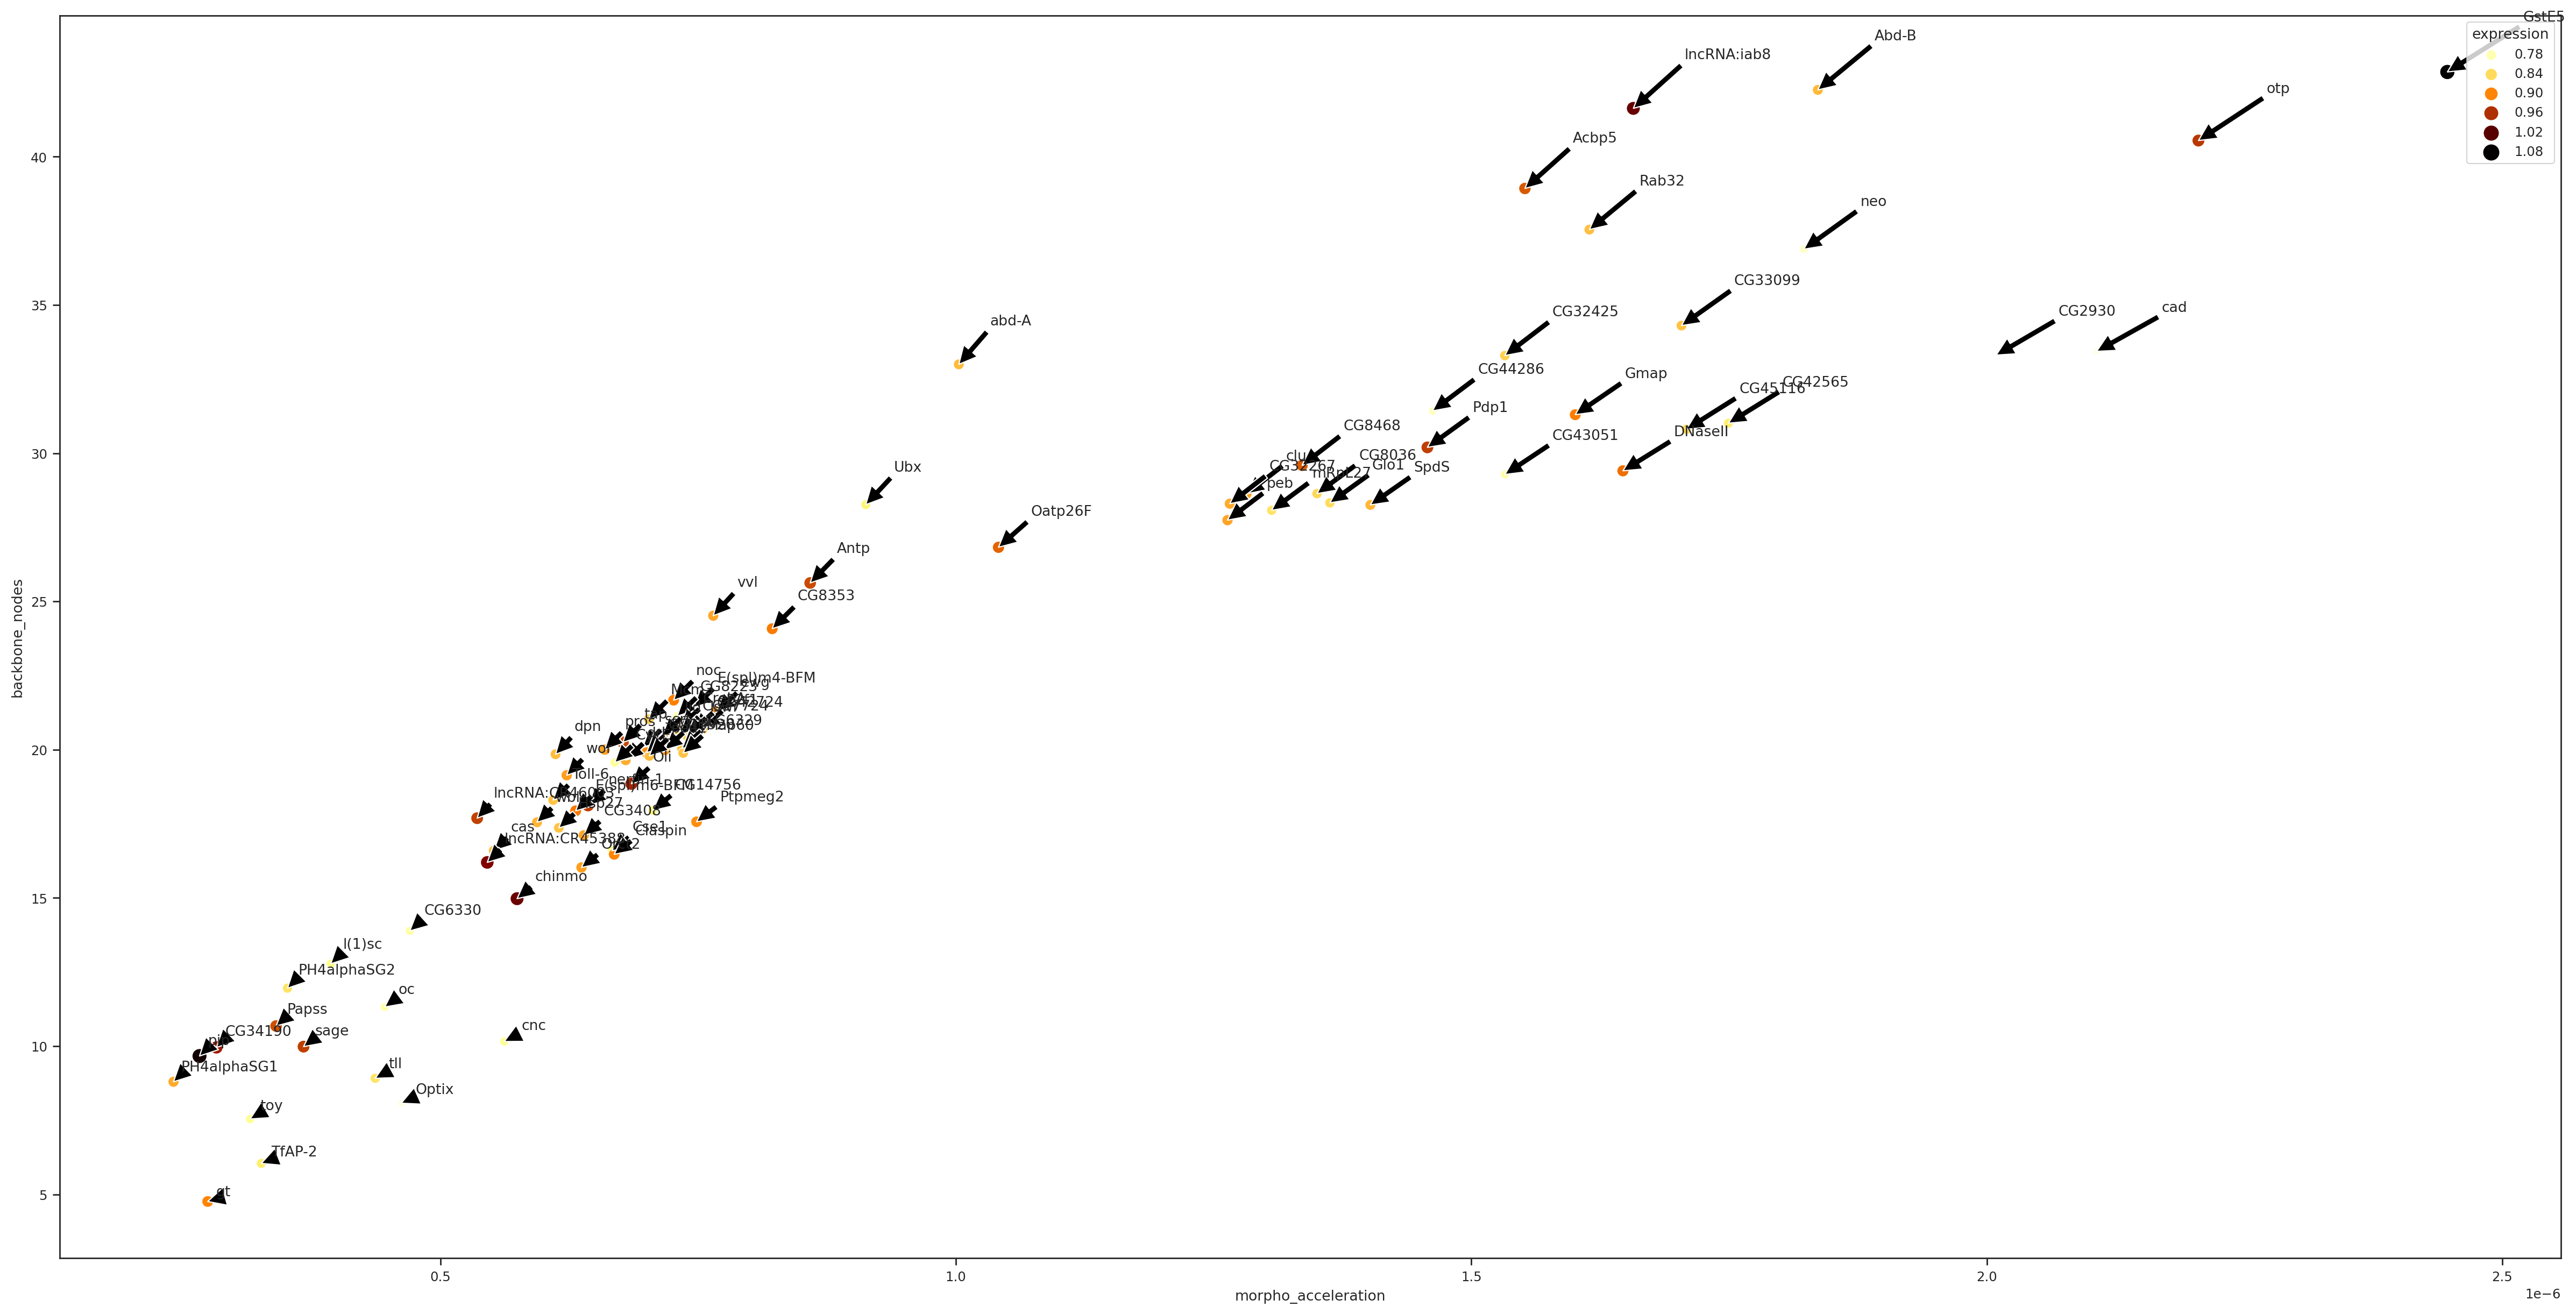

In [27]:
sns.set_theme(context="paper", style="ticks", font="Arial")
f, ax = plt.subplots(figsize=(30, 15))
sns.scatterplot(x="morpho_acceleration", y="backbone_nodes", data=completed_mean_data, hue="expression", size="expression", palette="afmhot_r", sizes=(20, 100), ax=ax)

acceleration_genes = [
    "Gmap", "otp","CG32425","DNaseII","SpdS","Pdp1","CG45116","CG8036","CG2930","CG33099",
    "CG42565","cad","CG32267","GstE5","CG8468","CG44286","peb","Glo1","CG43051","mRpL27","clu",
]
for i in range(len(completed_mean_data)):
    data = completed_mean_data.iloc[i, :]
    ax.annotate(data["GNs"], xy=(data["morpho_acceleration"], data["backbone_nodes"]), xytext=(data["morpho_acceleration"] * 1.03, data["backbone_nodes"] * 1.04),
                arrowprops=dict(facecolor='black', shrink=0.001))
plt.savefig(os.path.join(out_image_path, f"{sample_id}_germband_morpho_acceleration_glm_degs_mean_points_with_labels.pdf"), dpi=300, format="pdf", bbox_inches="tight")
plt.show()

In [30]:
st.pl.three_d_plot(
        model=germ_pc,
        key="morpho_curl",
        model_style="points",
        model_size=14,
        opacity=1,
        colormap="afmhot_r",
        show_legend=True,
        jupyter=False,
        cpo=cpo,
        window_size=(2560, 2048),
    )

([(-31.389489056849133, 822.0672881528578, -104.29118272311966),
  (13.0, 8.0, -3.0),
  (0.028036860857194913, 0.12493073213775896, 0.9917692506832414)],
 pyvista_ndarray([[[255, 255, 255],
                   [255, 255, 255],
                   [255, 255, 255],
                   ...,
                   [255, 255, 255],
                   [255, 255, 255],
                   [255, 255, 255]],
 
                  [[255, 255, 255],
                   [255, 255, 255],
                   [255, 255, 255],
                   ...,
                   [255, 255, 255],
                   [255, 255, 255],
                   [255, 255, 255]],
 
                  [[255, 255, 255],
                   [255, 255, 255],
                   [255, 255, 255],
                   ...,
                   [255, 255, 255],
                   [255, 255, 255],
                   [255, 255, 255]],
 
                  ...,
 
                  [[255, 255, 255],
                   [255, 255, 255],
                   [

## Save curl_related anndata object

In [31]:
germ_adata

AnnData object with n_obs × n_vars = 12585 × 8120
    obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'scc', 'anno_tissue_new', 'V_z', 'anno_germ_layer_new', 'backbone_nodes', 'backbone_scc', 'segments', 'morpho_acceleration', 'morpho_curvature', 'morpho_curl', 'morpho_torsion'
    uns: 'VecFld_morpho', 'glm_degs', 'log1p', 'pp'
    obsm: '2d_realign_spatial', '3d_align_spatial', 'V_cells_mapping', 'X_cells_mapping', 'X_pca', 'X_umap', 'morpho_acceleration', 'morpho_curl', 'morpho_curvature', 'morpho_velocity', 'raw_spatial', 'tdr_spatial'
    layers: 'X_counts', 'spliced', 'unspliced'

In [32]:
germ_adata.write_h5ad(f"h5ad/{sample_id}_germband_v4_acceleration.h5ad", compression="gzip")